In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install plotly-express transformers bert-extractive-summarizer sacremoses rouge_score SentencePiece datasets tqdm spacy sentence_transformers finbert_embedding fuzzywuzzy python-Levenshtein 
!ls drive/MyDrive/Colab\ Notebooks/training/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 5.3 MB/s 
     |████████████████████████████████| 880 kB 43.1 MB/s 
     |████████████████████████████████| 1.2 MB 51.9 MB/s 
     |████████████████████████████████| 365 kB 59.4 MB/s 
     |████████████████████████████████| 85 kB 5.2 MB/s 
     |████████████████████████████████| 50 kB 6.5 MB/s 
     |████████████████████████████████| 6.6 MB 39.6 MB/s 
     |████████████████████████████████| 596 kB 49.8 MB/s 
     |████████████████████████████████| 101 kB 13.2 MB/s 
     |████████████████████████████████| 141 kB 64.7 MB/s 
     |████████████████████████████████| 212 kB 45.0 MB/s 
     |████████████████████████████████| 127 kB 49.4 MB/s 
     |████████████████████████████████| 123 kB 48.3 MB/s 
     |████████████████████████████████| 132 kB 47.6 MB/s 
     |████████████████████████████████| 9.0 MB 39.5 MB/s 
     |██████████████████████████████

In [ ]:
import os
from genericpath import exists
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
import re
import numpy as np
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import pandas as pd
import matplotlib.pyplot as plt
import torch 
from transformers import AutoTokenizer,AutoModel, AutoModelForSequenceClassification ,AutoConfig
from transformers.modeling_outputs import TokenClassifierOutput
from torch import nn
from rouge_score import rouge_scorer
from tqdm.auto import tqdm

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


System overview

1.   File Path list
2.   Test and train Split
3.   Take a file
4.   Get Sentances Apart
5.   Check Ranking
6.   Save Ranking and Sentance as a pickle
7.   Model Create 
8.   Tokenizer initialize
9.   Get the loss from model
10.  Get the testing FilePath list
11.  Geting F1 scores and 
12.  Geting summary 





 


File Path List

In [ ]:
#Bhavesh 
fpath = 'drive/MyDrive/Colab Notebooks/Colab Notebooks/training/'
reports = fpath+'annual_reports'
summaries = fpath+'gold_summaries'
pickles = fpath+'pickle'
if (not os.path.exists(pickles)):
  os.mkdir(pickles)
os.listdir(reports),os.listdir(summaries)
freports = [(reports+'/'+i,*i.rsplit('.',1)) for i in os.listdir(reports)]


In [ ]:
#Jitesh
fpath = 'drive/MyDrive/Colab Notebooks/training/'
reports = fpath+'annual_reports'
summaries = fpath+'gold_summaries'
pickles = fpath+'pickle'
os.listdir(reports),os.listdir(summaries)
freports = [(reports+'/'+i,*i.rsplit('.',1)) for i in os.listdir(reports)]


Test and train Split


In [ ]:
len(freports)
import random
#Randomizing Reports
set_of_all_reports = set(range(len(freports)))
dataset1 =  set(random.sample(set_of_all_reports, int(len(freports)*0.6)))
dataset2 = set_of_all_reports - dataset1
#Training and Test Split 60-40 Split
freports_part = [freports[i] for i in dataset1]
freports_train =[(freports_part[j][0],freports_part[j][1],[summaries+'/'+freports_part[j][1]+'_'+str(i)+'.'+freports_part[0][2] for i in range(1,4)])for j in range(len(freports_part))]
freports_part = [freports[i] for i in dataset2]
freports_test =[(freports_part[j][0],freports_part[j][1],[summaries+'/'+freports_part[j][1]+'_'+str(i)+'.'+freports_part[0][2] for i in range(1,4)])for j in range(len(freports_part))]


Take a file

Get Sentances Apart

Check Ranking

Save Ranking and Sentance as a pickle

In [ ]:

def make_sentances(file):
  #Get Sentances Apart
  rep = file.read()
  rep=re.sub('\s',' ', rep)
  rep=re.sub('<','.', rep)
  rep=re.sub('>','.',rep)
  #dweviding the paragraph into smaller sentances
  sent=sent_tokenize(rep)
  return sent

def contains_sentance(sentance,summary_sentances):
  #Check Sentance matching using fuzzyscore
  matching  = False
  for j in range(np.shape(summary_sentances)[0]):
    matching =  (fuzz.token_set_ratio(sentance,summary_sentances[j])>75)
    if (matching):
      break
  return matching

def make_pickle(report_path,file_name,summ_array_path):
  #making training data pickle
  #Showing the result if already computed (Time Complexity)
  result_file_path = pickles+'/'+file_name+'.pickle'
  if(os.path.exists(result_file_path)):
    #returning the DataFrame
    return pd.read_pickle(result_file_path)
  final=[]
  #opening the file
  with open(report_path) as f:
    #getting all the sentances
    sent = make_sentances(f)
    #getting summaries sentances
    summaries=[]
    for i in range(len(summ_array_path)):
      if os.path.exists(summ_array_path[i]):
        with open(summ_array_path[i]) as s:
          summaries.append(make_sentances(s))
    #setting the positive score for sentances found in the summaries
    positive_score = (1/len(summaries))
    #ranking each sentance in the report according to the fuzzy score between them
    for i in range(np.shape(sent)[0]):
      count=0
      for sent_sum in summaries:
        if(contains_sentance(sent[i],sent_sum)):
          count = count + positive_score
      final.append([sent[i],count])
  #saving the sentance with the ranking in a pickle file for reducing time complexity 
  final_1=pd.DataFrame(final)
  result_file_path = pickles+'/'+file_name+'.pickle'
  final_1.to_pickle(result_file_path)
  #returning the DataFrame 
  return final_1

def calc_rouge_scores(pred_summaries, gold_summaries, 
                                 keys=['rouge1', 'rougeL'], use_stemmer=True):
  #Calculate rouge scores
  scorer = rouge_scorer.RougeScorer(keys, use_stemmer= use_stemmer)
  n = len(pred_summaries)
  #scoring all summaries 
  scores = [scorer.score(pred_summaries[j], gold_summaries[j]) for 
            j in range(n)] 
            
  #create dict
  dict_scores={}                                                            
  for key in keys:
      dict_scores.update({key: {}})
      
  #populate dict with mean of all scores
  for key in keys:
      
      precision_list = [scores[j][key][0] for j in range(len(scores))]
      recall_list = [scores[j][key][1] for j in range(len(scores))]
      f1_list = [scores[j][key][2] for j in range(len(scores))]

      precision = np.mean(precision_list)
      recall = np.mean(recall_list)
      f1 = np.mean(f1_list)
      
      dict_results = {'recall': recall, 'precision': precision, 'f1': f1}
      
      dict_scores[key] = dict_results
  return dict_scores

def fill0(data,max_size=512):
  # Get lengths of each row of data
  if(len(data)<max_size):
    for i in range(max_size-len(data)):
      data.append(0)
  return data



In [ ]:
class SummarizationFinBERTModel(nn.Module):
  def __init__(self,checkpoint):
    super(SummarizationFinBERTModel,self).__init__()
    model = AutoModel.from_pretrained(checkpoint,config=AutoConfig.from_pretrained(checkpoint, output_attentions=True,output_hidden_states=True))
    self.model = model 
    self.dropout = nn.Dropout(0.1) 
    #additional Layer for Sentance ranking
    self.classifier = nn.Linear(768,1) #https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_linear_regression/

  def forward(self, input_ids=None, attention_mask=None,label=None,token_type_ids=None):
    #taking the data through the finbert model 
    outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
    #getting the last hidden state for input
    hidden_states = outputs.hidden_states
    sequence_output = self.dropout(hidden_states[0])
    #Getting the output from the new layer's output
    logits = self.classifier(sequence_output[:,0,:].view(-1,768))
    #Calculating the loss
    loss = None
    loss_fct = nn.L1Loss()
    if(label):
      loss = loss_fct(logits.view(-1, 1), torch.tensor(label))
    #Returning all data.
    return TokenClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states,attentions=outputs.attentions)

In [ ]:
#Base model 
checkpoint = "ProsusAI/finbert"
learning_rate = 0.03
#Tokenizer initialized
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenizer.model_max_len=512
#model initialized
model = SummarizationFinBERTModel(checkpoint)
#optimizer initialized
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
#tokenizer fn setup
def tokenize(sentance):
  resultpre = tokenizer(sentance[0],truncation = True, max_length=512,padding= True)
  return {'input_ids':resultpre['input_ids'],'token_type_ids':resultpre['token_type_ids'],
          'attention_mask':resultpre['attention_mask'],'sentance':sentance[0],'output':sentance[1]}


Some weights of the model checkpoint at ProsusAI/finbert were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


epochs:


  0%|          | 0/2 [00:00<?, ?it/s]

files:


  0%|          | 0/6 [00:00<?, ?it/s]

sentances:


  0%|          | 0/456 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


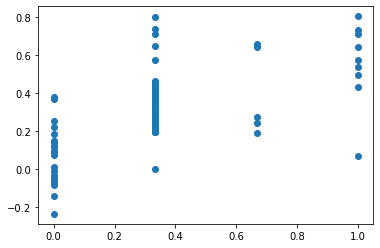

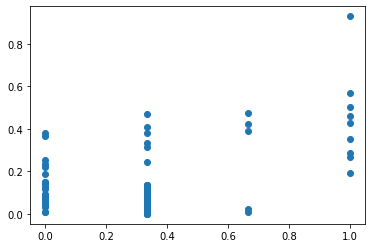

drive/MyDrive/Colab Notebooks/training/annual_reports/19.txt [-0.1999999999999993, 0.20000000000000284, 86.2, 82.2, 2.85, 91.2] Avg Loss for file: 0.12658968567848206
sentances:


  0%|          | 0/680 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


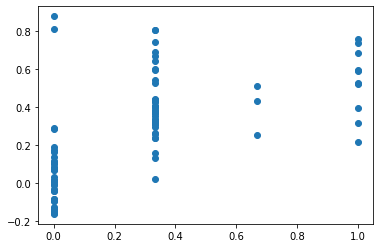

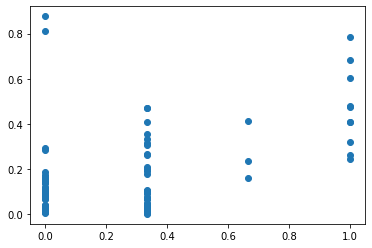

drive/MyDrive/Colab Notebooks/training/annual_reports/66.txt [0.0, 97.0, 133.0, 126.0, 4.25, 136.0] Avg Loss for file: 0.1823374181985855
sentances:


  0%|          | 0/781 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


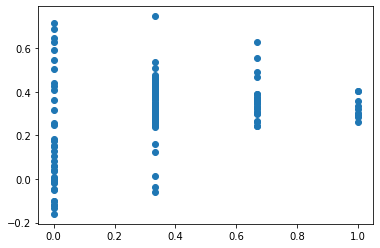

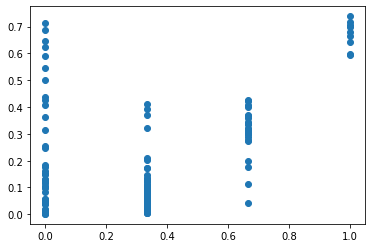

drive/MyDrive/Colab Notebooks/training/annual_reports/67.txt [-0.9500000000000028, 69.19999999999999, 133.2, 147.2, 4.88125, 156.2] Avg Loss for file: 0.17939279973506927
sentances:


  0%|          | 0/789 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


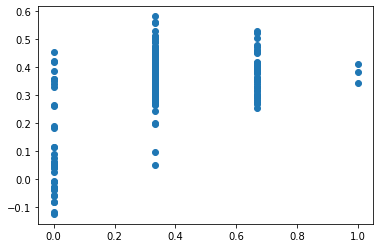

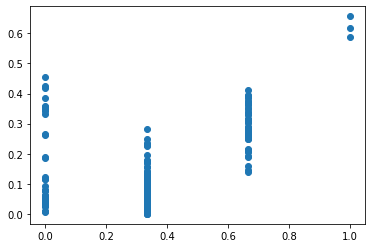

drive/MyDrive/Colab Notebooks/training/annual_reports/73.txt [-0.5499999999999972, -0.19999999999998863, 108.80000000000001, 154.8, 4.93125, 157.8] Avg Loss for file: 0.12417560815811157
sentances:


  0%|          | 0/766 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


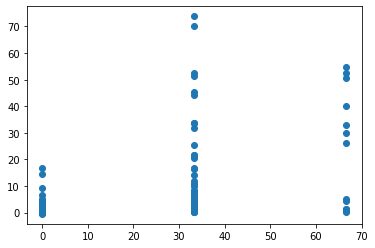

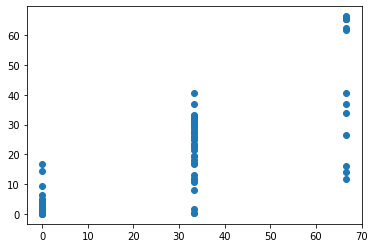

drive/MyDrive/Colab Notebooks/training/annual_reports/92.txt [-0.7000000000000028, 153.2, 153.2, 46.19999999999999, 4.7875, 153.2] Avg Loss for file: 22.928390502929688
sentances:


  0%|          | 0/766 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


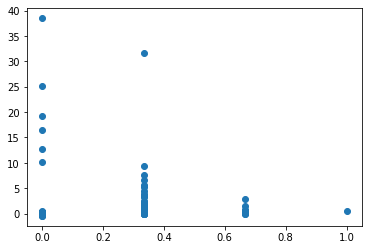

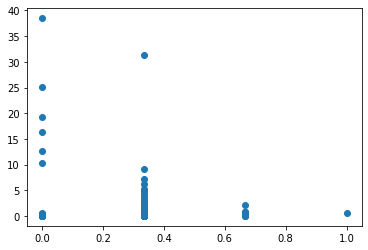

drive/MyDrive/Colab Notebooks/training/annual_reports/72.txt [-0.7000000000000028, 3.1999999999999886, 139.2, 152.2, 4.7875, 153.2] Avg Loss for file: 1.2034776210784912
files:


  0%|          | 0/6 [00:00<?, ?it/s]

sentances:


  0%|          | 0/456 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


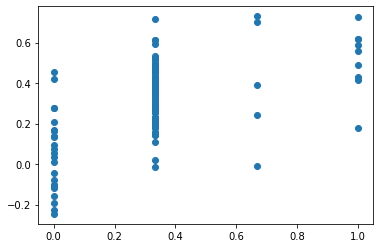

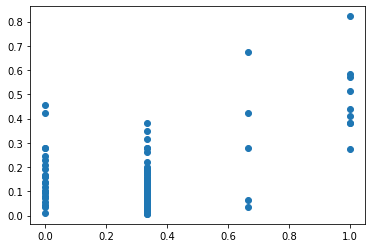

drive/MyDrive/Colab Notebooks/training/annual_reports/19.txt [-0.1999999999999993, 0.20000000000000284, 86.2, 82.2, 2.85, 91.2] Avg Loss for file: 0.14832235872745514
sentances:


  0%|          | 0/680 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


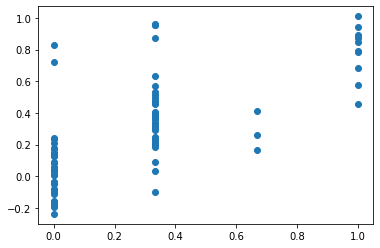

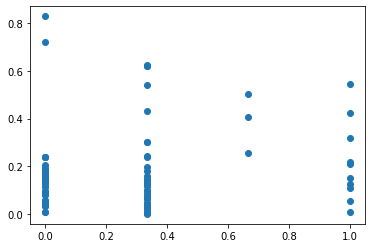

drive/MyDrive/Colab Notebooks/training/annual_reports/66.txt [0.0, 97.0, 133.0, 126.0, 4.25, 136.0] Avg Loss for file: 0.17419588565826416
sentances:


  0%|          | 0/781 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


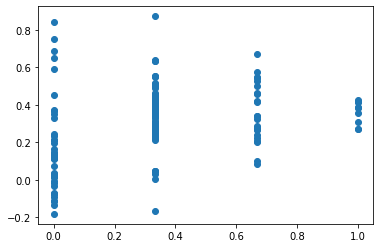

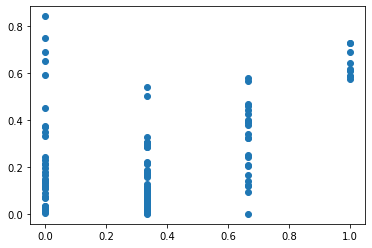

drive/MyDrive/Colab Notebooks/training/annual_reports/67.txt [-0.9500000000000028, 69.19999999999999, 133.2, 147.2, 4.88125, 156.2] Avg Loss for file: 0.19462357461452484
sentances:


  0%|          | 0/789 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


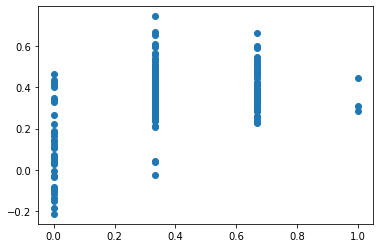

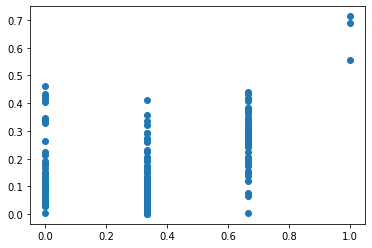

drive/MyDrive/Colab Notebooks/training/annual_reports/73.txt [-0.5499999999999972, -0.19999999999998863, 108.80000000000001, 154.8, 4.93125, 157.8] Avg Loss for file: 0.14224694669246674
sentances:


  0%|          | 0/766 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


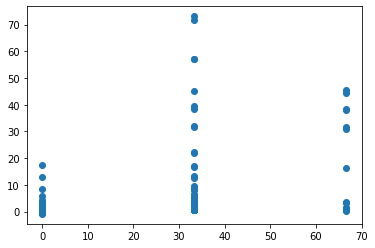

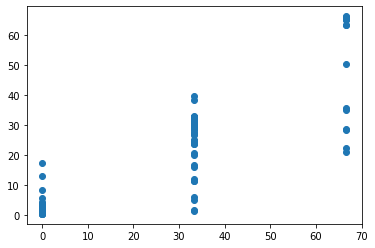

drive/MyDrive/Colab Notebooks/training/annual_reports/92.txt [-0.7000000000000028, 153.2, 153.2, 46.19999999999999, 4.7875, 153.2] Avg Loss for file: 23.59688377380371
sentances:


  0%|          | 0/766 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


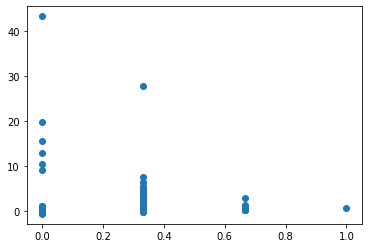

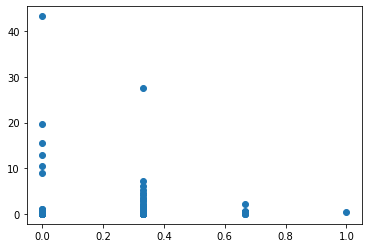

drive/MyDrive/Colab Notebooks/training/annual_reports/72.txt [-0.7000000000000028, 3.1999999999999886, 139.2, 152.2, 4.7875, 153.2] Avg Loss for file: 1.1284252405166626


In [ ]:
num_training_steps =0
#setting number of epochs (Running the code set multiple times to reach higher epoch numbers)
num_epochs = 2
print('epochs:')
progress_bar_epoch = tqdm(range(num_epochs))
#setting batch size 
batch_size = 1

for ep in range(num_epochs):
  print('files:')
  progress_bar_train = tqdm(range(len(freports_train)))
  inputts = []
  labells = []
  attenrionns = []
  for paths in freports_train:
    #For each file in training list
    file_pickle = make_pickle(*paths)
    print('sentances:')
    progress_bar_pickle = tqdm(range(len(file_pickle)))
    loss_sum = 0
    loss_count = 0

    len_of_input = 0
    max_len_of_input = 0
    batch_count = 0
    count_of_each_rank = [len(file_pickle)/5 for i in range(6)]
    count_of_each_rank[0]=count_of_each_rank[0]/32
    count_of_each_rank[0]=count_of_each_rank[1]/4
    count_of_each_rank[4]=count_of_each_rank[4]/32
    loss_graph=[[],[],[]]
    for i in range(len(file_pickle)):
      #for each sentance in file 
      #tokenizing sentance
      tokenized = tokenize([file_pickle[0][i],file_pickle[1][i]])
      #batching sentances
      rank_type=0
      if(tokenized['output']>0.8):
        rank_type=3
      elif(tokenized['output']>0.5):
        rank_type=2
      elif(tokenized['output']>0.2):
        rank_type=1
      if(not count_of_each_rank[rank_type]>0):
        progress_bar_pickle.update(1)
        continue
      count_of_each_rank[rank_type] = count_of_each_rank[rank_type]-1

      inputts.append(fill0(tokenized['input_ids'],512))
      labells.append(float(tokenized['output']))
      attenrionns.append(fill0(tokenized['attention_mask'],512))
      batch_count = batch_count+1
      if(batch_count >=batch_size):

        inputs = torch.tensor(inputts)
        labels = torch.tensor(labells)
        attenrions = torch.tensor(attenrionns)
        
        inputts = []
        labells = []
        attenrionns = []
        #Sending batches into the model to get ranking 
        outputs = model(input_ids=inputs, attention_mask=attenrions,label=labels)
        #getting loss 
        loss = outputs.loss
        #graphing loss for loss analysis
        loss_graph[0].append(float(tokenized['output']))
        loss_graph[1].append(float(outputs['logits']))
        loss_graph[2].append(float(loss))
        #Avg loss in training to check progress
        loss_sum  =outputs.loss +loss_sum
        loss_count = loss_count+1
        num_training_steps = num_training_steps +1
        #Backword propogating
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        progress_bar_pickle.update(batch_count)
        batch_count=0
    
    if(loss_count>0):
      #Loss graph ploting for each File 
      #Acutal Output vs Actual Output 
      plt.scatter(x=loss_graph[0], y=loss_graph[1] )
      plt.show()
      #Loss graph ploting for each File
      #Acutal Output vs Loss 
      plt.scatter(x=loss_graph[0], y=loss_graph[2] )
      plt.show()
      loss_graph=[[],[],[]]
      #Printing Avg Loss for file
      print(paths[0],count_of_each_rank,'Avg Loss for file:',float(loss_sum/loss_count))
    else:
      print(paths[0],'Zero loss as zero files found')
    progress_bar_train.update(1)
  progress_bar_epoch.update(1)


In [ ]:
print('Testing:')
#testing 
keys=['rouge1','rouge2', 'rougeL']
use_stemmer=True
#rouge Scorer
scorer = rouge_scorer.RougeScorer(keys, use_stemmer= use_stemmer)
progress_bar_eval = tqdm(range(len(freports_test)))
for paths in freports_test:
  #for file in test list
  #getting sentances
  file_pickle = make_pickle(*paths)
  summaries_index_list = []
  print('Files:')
  progress_bar_pickle = tqdm(range(len(file_pickle)))
  for i in range(len(file_pickle)):
    #for sentances in file 
    #tokenizing sentance
    tokenized = tokenize([file_pickle[0][i],file_pickle[1][i]]) 
    inputs = torch.tensor([tokenized['input_ids']])
    labels = torch.tensor([float(tokenized['output'])])
    attenrions = torch.tensor([tokenized['attention_mask']])
    #getting output for sentance
    outputs = model(input_ids=inputs, attention_mask=attenrions,label=labels)
    #Setting a threshold for output sentances
    if (outputs['logits'] > 0.4):
      print(outputs['logits'],end='')
      summaries_index_list.append(i)
    progress_bar_pickle.update(1)
    if(len(summaries_index_list)>50):
      print(i,len(summaries_index_list))
      break
  #generate Summary
  summary = ''.join([ file_pickle[0][i] for i in summaries_index_list ])
  #Checking ROUGE SCORES for predicted summaries and gold summaries
  dict_scores = {}
  scores=[]
  for summary_path in paths[2]:
    with open(summary_path) as r:
      #for each gold summary get scores for predicted data
      scores.append(scorer.score(summary,r.read()))
  #average of scores
  for key in keys:
    precision_list = [scores[j][key][0] for j in range(len(scores))]
    recall_list = [scores[j][key][1] for j in range(len(scores))]
    f1_list = [scores[j][key][2] for j in range(len(scores))]

    precision = np.mean(precision_list)
    recall = np.mean(recall_list)
    f1 = np.mean(f1_list)
    
    dict_results = {'recall': recall, 'precision': precision, 'f1': f1}
    
    dict_scores[key] = dict_results
  print()
  #printing Scores 
  [print(key,dict_scores[key]) for key in keys]
  progress_bar_eval.update(1)


Testing:


  0%|          | 0/4 [00:00<?, ?it/s]

Files:


  0%|          | 0/591 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


tensor([[0.4119]], grad_fn=<AddmmBackward0>)tensor([[0.4038]], grad_fn=<AddmmBackward0>)tensor([[0.4121]], grad_fn=<AddmmBackward0>)tensor([[0.4208]], grad_fn=<AddmmBackward0>)tensor([[0.4061]], grad_fn=<AddmmBackward0>)tensor([[0.4154]], grad_fn=<AddmmBackward0>)tensor([[0.4486]], grad_fn=<AddmmBackward0>)tensor([[0.4733]], grad_fn=<AddmmBackward0>)tensor([[0.4340]], grad_fn=<AddmmBackward0>)tensor([[0.4192]], grad_fn=<AddmmBackward0>)tensor([[0.4393]], grad_fn=<AddmmBackward0>)tensor([[0.4078]], grad_fn=<AddmmBackward0>)tensor([[0.4008]], grad_fn=<AddmmBackward0>)tensor([[0.4021]], grad_fn=<AddmmBackward0>)tensor([[0.4051]], grad_fn=<AddmmBackward0>)tensor([[0.4032]], grad_fn=<AddmmBackward0>)tensor([[0.4072]], grad_fn=<AddmmBackward0>)tensor([[0.4012]], grad_fn=<AddmmBackward0>)tensor([[0.4530]], grad_fn=<AddmmBackward0>)tensor([[0.4572]], grad_fn=<AddmmBackward0>)tensor([[0.4385]], grad_fn=<AddmmBackward0>)tensor([[0.4366]], grad_fn=<AddmmBackward0>)tensor([[0.4426]], grad_fn=<Addm

  0%|          | 0/386 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


tensor([[0.4024]], grad_fn=<AddmmBackward0>)tensor([[0.4241]], grad_fn=<AddmmBackward0>)tensor([[0.4213]], grad_fn=<AddmmBackward0>)tensor([[0.4258]], grad_fn=<AddmmBackward0>)tensor([[0.4337]], grad_fn=<AddmmBackward0>)tensor([[0.4345]], grad_fn=<AddmmBackward0>)tensor([[0.4440]], grad_fn=<AddmmBackward0>)tensor([[0.4188]], grad_fn=<AddmmBackward0>)tensor([[0.4021]], grad_fn=<AddmmBackward0>)tensor([[0.4238]], grad_fn=<AddmmBackward0>)tensor([[0.4006]], grad_fn=<AddmmBackward0>)tensor([[0.4180]], grad_fn=<AddmmBackward0>)tensor([[0.4026]], grad_fn=<AddmmBackward0>)tensor([[0.4088]], grad_fn=<AddmmBackward0>)tensor([[0.4394]], grad_fn=<AddmmBackward0>)tensor([[0.4663]], grad_fn=<AddmmBackward0>)
rouge1 {'recall': 0.3279467680608365, 'precision': 0.47889103705160085, 'f1': 0.3726690075061065}
rouge2 {'recall': 0.12400888043133523, 'precision': 0.17676361359080017, 'f1': 0.1387592393589893}
rougeL {'recall': 0.14480354879594423, 'precision': 0.1978647961538806, 'f1': 0.15948138631932782}

  0%|          | 0/651 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


tensor([[0.4193]], grad_fn=<AddmmBackward0>)tensor([[0.4238]], grad_fn=<AddmmBackward0>)tensor([[0.4449]], grad_fn=<AddmmBackward0>)tensor([[0.4246]], grad_fn=<AddmmBackward0>)tensor([[0.4479]], grad_fn=<AddmmBackward0>)tensor([[0.4271]], grad_fn=<AddmmBackward0>)tensor([[0.4413]], grad_fn=<AddmmBackward0>)tensor([[0.4058]], grad_fn=<AddmmBackward0>)tensor([[0.4166]], grad_fn=<AddmmBackward0>)tensor([[0.4036]], grad_fn=<AddmmBackward0>)tensor([[0.4037]], grad_fn=<AddmmBackward0>)tensor([[0.4455]], grad_fn=<AddmmBackward0>)tensor([[0.4328]], grad_fn=<AddmmBackward0>)tensor([[0.4130]], grad_fn=<AddmmBackward0>)tensor([[0.4541]], grad_fn=<AddmmBackward0>)tensor([[0.4184]], grad_fn=<AddmmBackward0>)tensor([[0.4615]], grad_fn=<AddmmBackward0>)tensor([[0.4078]], grad_fn=<AddmmBackward0>)tensor([[0.4112]], grad_fn=<AddmmBackward0>)tensor([[0.4703]], grad_fn=<AddmmBackward0>)tensor([[0.4006]], grad_fn=<AddmmBackward0>)tensor([[0.4139]], grad_fn=<AddmmBackward0>)tensor([[0.4458]], grad_fn=<Addm

  0%|          | 0/664 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


tensor([[0.4181]], grad_fn=<AddmmBackward0>)tensor([[0.4288]], grad_fn=<AddmmBackward0>)tensor([[0.4024]], grad_fn=<AddmmBackward0>)tensor([[0.4164]], grad_fn=<AddmmBackward0>)tensor([[0.4017]], grad_fn=<AddmmBackward0>)tensor([[0.4178]], grad_fn=<AddmmBackward0>)tensor([[0.4231]], grad_fn=<AddmmBackward0>)tensor([[0.4053]], grad_fn=<AddmmBackward0>)tensor([[0.4103]], grad_fn=<AddmmBackward0>)tensor([[0.4838]], grad_fn=<AddmmBackward0>)tensor([[0.4145]], grad_fn=<AddmmBackward0>)tensor([[0.4050]], grad_fn=<AddmmBackward0>)tensor([[0.4189]], grad_fn=<AddmmBackward0>)tensor([[0.4005]], grad_fn=<AddmmBackward0>)tensor([[0.4532]], grad_fn=<AddmmBackward0>)tensor([[0.4622]], grad_fn=<AddmmBackward0>)tensor([[0.4361]], grad_fn=<AddmmBackward0>)tensor([[0.4041]], grad_fn=<AddmmBackward0>)tensor([[0.4065]], grad_fn=<AddmmBackward0>)tensor([[0.4642]], grad_fn=<AddmmBackward0>)tensor([[0.4057]], grad_fn=<AddmmBackward0>)tensor([[0.4013]], grad_fn=<AddmmBackward0>)tensor([[0.4506]], grad_fn=<Addm

EOF


  0%|          | 0/456 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Lets see


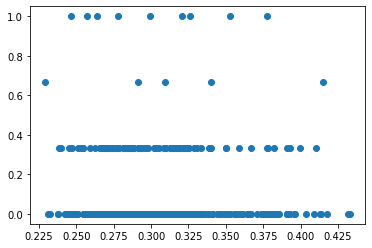

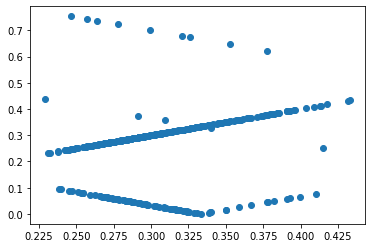

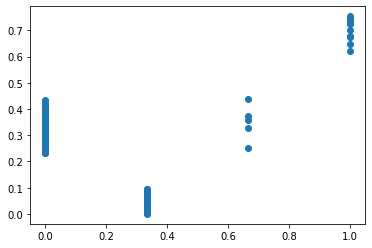

Done



  0%|          | 0/680 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Lets see


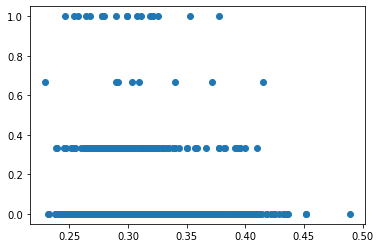

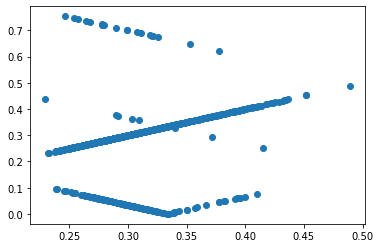

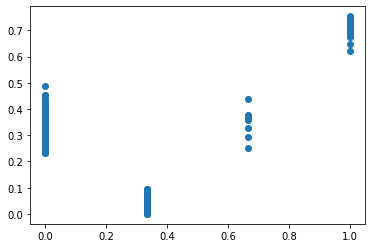

Done



  0%|          | 0/781 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Lets see


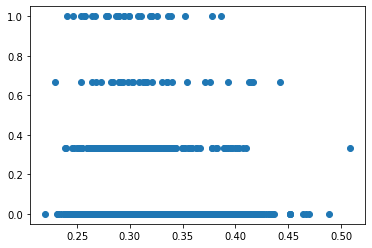

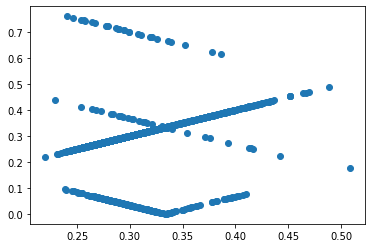

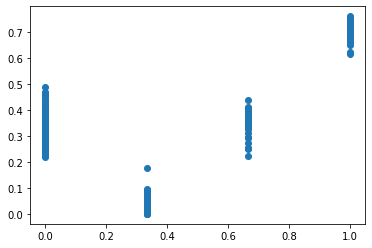

Done



  0%|          | 0/789 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Lets see


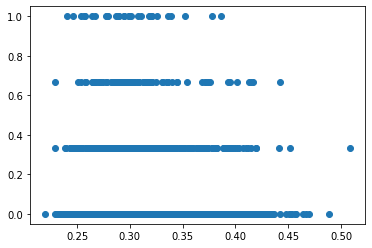

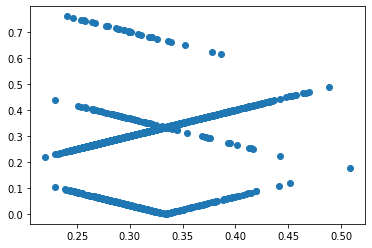

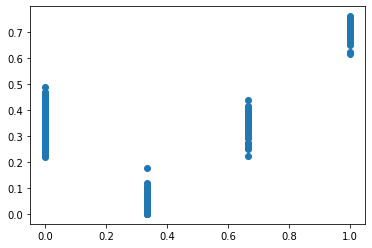

Done



  0%|          | 0/766 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Lets see


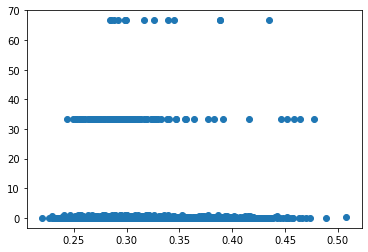

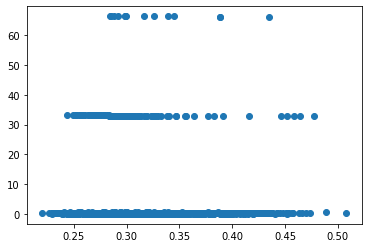

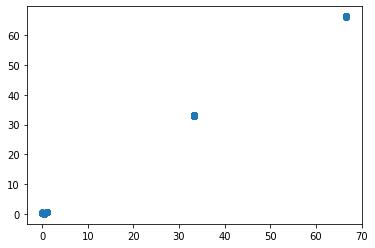

Done



  0%|          | 0/766 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Lets see


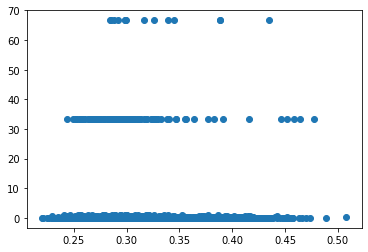

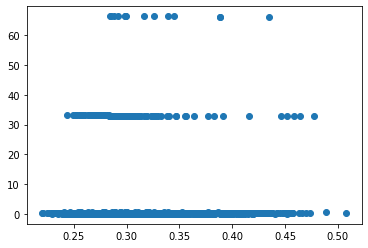

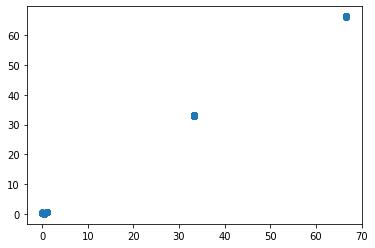

Done



In [ ]:
loss_graph=[[],[],[]]
for paths in freports_train:
  file_pickle = make_pickle(*paths)
  progress_bar_eval = tqdm(range(len(file_pickle)))
  for i in range(len(file_pickle)):
    tokenized = tokenize([file_pickle[0][i],file_pickle[1][i]]) 
    inputs = torch.tensor([tokenized['input_ids']])
    labels = torch.tensor([tokenized['output']])
    attenrions = torch.tensor([tokenized['attention_mask']])
    outputs = model(input_ids=inputs, attention_mask=attenrions,label=labels)
    loss_graph[0].append(float(outputs['logits']))
    loss_graph[1].append(float(tokenized['output']))
    loss_graph[2].append(float(outputs.loss))
    progress_bar_eval.update(1)
    #print(outputs['logits'],outputs['logits']>0.8)
  print('Lets see')
  #Predicted Output Vs actual Output
  plt.scatter(x=loss_graph[0], y=loss_graph[1] )
  plt.show()
  #Predicted Output Vs Loss
  plt.scatter(x=loss_graph[0], y=loss_graph[2] )
  plt.show()
  # actual Output vs Loss
  plt.scatter(x=loss_graph[1], y=loss_graph[2] )
  plt.show()
  print('Done')
  print()